In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import itertools, operator, random, math
from scipy.sparse.linalg import spsolve_triangular
from sklearn import linear_model
import utils as ut
import pandas as pd
from sklearn.model_selection import GridSearchCV
from scipy import interpolate
%matplotlib inline

In [2]:
dt = 1
t = np.linspace(0, 20, 21)
hare = np.array([30, 47.2, 70.2, 77.4, 36.3, 20.6, 18.1, 21.4, 22, 25.4, 27.1, 40.3, 57, 76.6, 52.3, 19.5, 11.2, 7.6, 14.6, 16.2, 24.7])
lynx = np.array([4, 6.1, 9.8, 35.2, 59.4, 41.7, 19, 13, 8.3, 9.1, 7.4, 8, 12.3, 19.5, 45.7, 51.1, 29.7,15.8, 9.7, 10.1, 8.6])


f_hare = interpolate.interp1d(t, hare, kind='slinear')
tnew = np.linspace(0, 20, 201)
hare_new = f_hare(tnew)

f_lynx = interpolate.interp1d(t, lynx, kind='slinear')
lynx_new = f_lynx(tnew)

# hare_interp = np.interp(np.linspace(0, 20, 201), t, hare)
# lynx_interp = np.interp(np.linspace(0, 20, 201), t, lynx)

pop_data1 = np.vstack([hare_new, lynx_new])
pop_data = np.hstack([pop_data1, pop_data1, pop_data1])
dpop1 = ut.time_different(0.1 ,pop_data1)
dpop = np.hstack([dpop1, dpop1, dpop1])
dpop_std = ut.time_different(dt, np.vstack([hare, lynx]))
t_new = np.hstack([tnew, tnew+20, tnew+40])

In [445]:
dpop.shape

(2, 603)

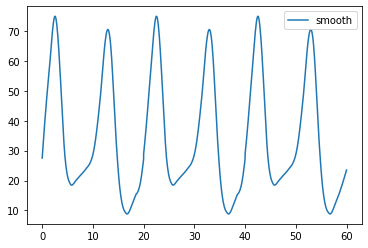

In [446]:
from scipy.signal import savgol_filter

smoothed_1dg = savgol_filter(pop_data, window_length = 31, polyorder = 2)
plt.plot(t_new, smoothed_1dg[0], label='smooth')
# plt.plot(t_new, pop_data[0], label ='true')
plt.legend()

In [463]:
 sp_label = ['h', 'l']
 theta, descr = ut.lib_terms(pop_data,2,sp_label)

In [482]:
clf = linear_model.Lasso(alpha=0, fit_intercept=False, max_iter=1e4)
clf.fit(theta,dpop.T)
Xi2 = clf.coef_

In [475]:
Xi = ut.sparsifyDynamics(theta, dpop.T, 0.01)

In [490]:
small_idx = abs(Xi2.T) < 1e-7
Xi[small_idx] = 0
new_set =  [x.replace('(', '').replace(']', '') for x in descr] 
name_s = sp_label
label = []
for str_ in new_set[1:]:
    idx_ = [int(x) for x in str_.split(') [')[0].split(',')]
    lab = ""
    for idx, i in enumerate(idx_):
        j = i
        while j > 0:
            lab += name_s[idx]
            j -= 1
    label.append(lab)

term_label = ['1'] + label

df_term = pd.DataFrame(Xi2.T, index=term_label, columns=name_s)


In [491]:
df_term

,h,l
1,3.151824,12.580338
l,-0.197902,-1.634163
h,0.340847,-0.316426
ll,0.005447,0.011931
hl,-0.028782,0.025437
hh,0.004260,0.003535


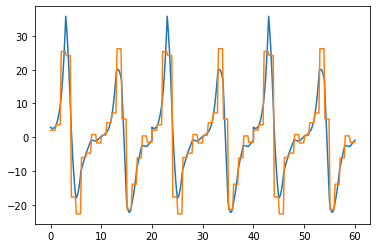

In [485]:
plt.plot(t_new, theta.dot(Xi2.T)[:,1])
plt.plot(t_new, dpop[1])

In [459]:
t.shape

(21,)

In [486]:
sol_res = integrate.solve_ivp(ut.sparseGalerkin, [tt[0], tt[-1]], pop_data[:,0], method='RK45', atol=1e-10, rtol=1e-10, t_eval=tt, args=(Xi2.T,2))

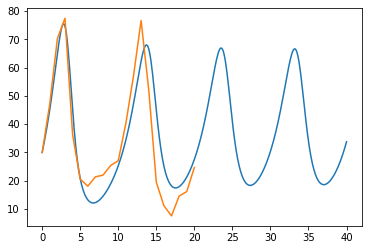

In [488]:

plt.plot(tt, sol_res.y[0])
plt.plot(t, hare)

# plt.plot(sol_res.y[1])
# plt.plot(lynx)


In [12]:
new_set

['1',
 "0, 1) ['h', 'l'",
 "1, 0) ['h', 'l'",
 "0, 2) ['h', 'l'",
 "1, 1) ['h', 'l'",
 "2, 0) ['h', 'l'"]

In [16]:
name_s[1]

'1'

test 2

In [3]:
dt = 1
t = np.linspace(0, 20, 21)
hare = np.array([30, 47.2, 70.2, 77.4, 36.3, 20.6, 18.1, 21.4, 22, 25.4, 27.1, 40.3, 57, 76.6, 52.3, 19.5, 11.2, 7.6, 14.6, 16.2, 24.7])
lynx = np.array([4, 6.1, 9.8, 35.2, 59.4, 41.7, 19, 13, 8.3, 9.1, 7.4, 8, 12.3, 19.5, 45.7, 51.1, 29.7,15.8, 9.7, 10.1, 8.6])

pop_data = np.vstack([hare, lynx])
dpop_data = ut.time_different(dt, pop_data)

f_dhare = interpolate.interp1d(t, dpop_data[0], kind='cubic')
dt_new = 0.01
tnew = np.linspace(0, 20, int(20/dt_new+2))
dhare = f_dhare(tnew)

f_dlynx = interpolate.interp1d(t, dpop_data[1], kind='cubic')
dlynx = f_dlynx(tnew)

In [4]:
hare1 = np.cumsum(dhare)*dt_new
hare1 += np.mean(hare) - np.mean(hare1)

lynx1  = np.cumsum(dlynx)*dt_new
lynx1 += np.mean(lynx) - np.mean(lynx1)

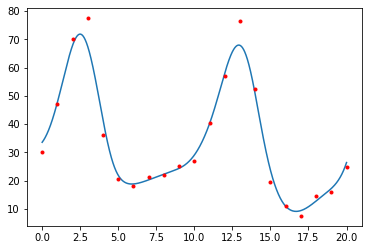

In [7]:
plt.plot(tnew, hare1)
# plt.plot(tnew, pop_data1[0])
plt.plot(t, hare, '.r')

In [14]:
pop_newnew = np.vstack([hare1, lynx1])

In [15]:
 sp_label = ['h', 'l']
 theta, descr = ut.lib_terms(pop_newnew,2,sp_label)

In [16]:
Xi = ut.sparsifyDynamics(theta,np.vstack([dhare, dlynx]).T, 0.01)

In [17]:
small_idx = abs(Xi) < 1e-7
Xi[small_idx] = 0
new_set =  [x.replace('(', '').replace(']', '') for x in descr] 
name_s = sp_label
label = []
for str_ in new_set[1:]:
    idx_ = [int(x) for x in str_.split(') [')[0].split(',')]
    lab = ""
    for idx, i in enumerate(idx_):
        j = i
        while j > 0:
            lab += name_s[idx]
            j -= 1
    label.append(lab)

term_label = ['1'] + label

df_term = pd.DataFrame(Xi, index=term_label, columns=name_s)

In [18]:
tt = np.linspace(0, 40, 401)

In [35]:
sol_res = integrate.solve_ivp(ut.sparseGalerkin, [tt[0], tt[-1]], pop_data[:,0], method='RK45', atol=1e-10, rtol=1e-10, t_eval=tt, args=(Xi,2))

In [110]:
len(sol_res.y[0])

401

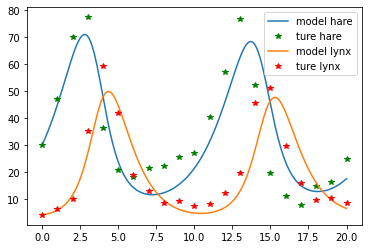

In [117]:
plt.plot(tt[:201], sol_res.y[0,:201], label='model hare')
plt.plot(t, hare, 'g*', label='ture hare ')
plt.plot(tt[:201], sol_res.y[1,:201], label='model lynx')
plt.plot(t, lynx, 'r*', label ='ture lynx')
plt.legend()

In [21]:
df_term

,h,l
1,-1.757703,0.356481
l,-0.069763,-0.881366
h,0.568811,0.044100
ll,0.000000,0.000000
hl,-0.023031,0.022462
hh,0.000000,0.000000


In [61]:
def LV(t, pop):
    a1, a2 = 0.4807, 0.02482
    b1, b2 = 0.9272, 0.02756

    h, l = pop
    dh = a1*h - a2*h*l
    dl = -b1*l + b2*h*l
    dpop = dh, dl
    return dpop

In [62]:
pop0 = [34.91, 3.857]
sol = integrate.solve_ivp(LV, [tt[0], tt[-1]], pop_data[:,0], method='RK45', atol=1e-10, rtol=1e-10, t_eval=tt)

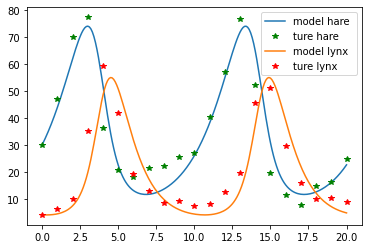

In [118]:
plt.plot(sol.t[:201], sol.y[0,:201], label='model hare ')
plt.plot(t, hare, 'g*', label='ture hare ')
plt.plot(sol.t[:201], sol.y[1,:201], label='model lynx')
plt.plot(t, lynx, 'r*', label ='ture lynx')
plt.legend()

In [64]:
diff_sol_res = sol_res.y[:,range(0,201,10)] - np.vstack([hare, lynx])
diff_res = sol.y[:,range(0,201,10)] - np.vstack([hare, lynx])

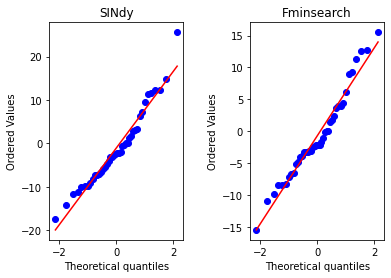

In [128]:
from scipy.stats import probplot
plt.subplot(121)
probplot(diff_sol_res.flatten(), dist="norm", plot=plt)
plt.title('SINdy')
plt.subplot(122)
probplot(diff_res.flatten(), dist="norm", plot=plt)
plt.title('Fminsearch')
# plt.plot(sol_res.t, sol_res.y[0])
# plt.xlim(-2, 2)
plt.subplots_adjust(wspace = 0.5)

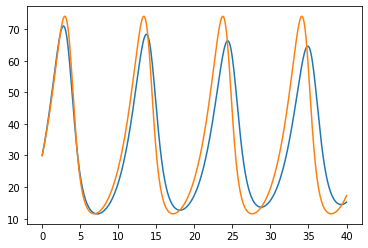

In [75]:
plt.plot(sol_res.t, sol_res.y[0])
plt.plot(sol.t, sol.y[0])

In [89]:
x_hare = np.hstack([ 20,30,50,52,80, 40,20,10,2,6, 15, 5, hare, 60, 70, 80])

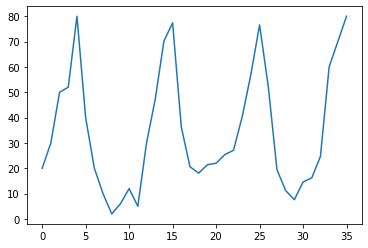

In [88]:
plt.plot(x)

In [152]:
# ttt = np.linspace(0,3,1)

In [180]:
ttt =np.linspace(0,36,361)
# ttt

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
        3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
        4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
        5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
        6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
        7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
        8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
        9.9, 10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9,
       11. , 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12. ,
       12.1, 12.2, 12.3, 12.4, 12.5, 12.6, 12.7, 12.8, 12.9, 13. , 13.1,
       13.2, 13.3, 13.4, 13.5, 13.6, 13.7, 13.8, 13.9, 14. , 14.1, 14.2,
       14.3, 14.4, 14.5, 14.6, 14.7, 14.8, 14.9, 15

In [181]:
sol2 = integrate.solve_ivp(LV, [ttt[0], ttt[-1]], [30, 4], method='RK45', atol=1e-10, rtol= 1e-10, t_eval=ttt)
sol_res2 = integrate.solve_ivp(ut.sparseGalerkin, [ttt[0], ttt[-1]], [30, 4], method='RK45', atol=1e-10, rtol=1e-10, t_eval=ttt, args=(Xi,2))

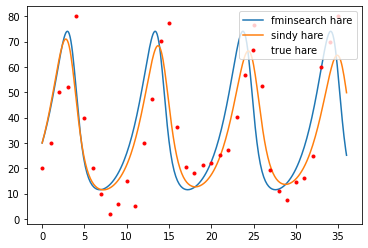

In [182]:
plt.plot(sol2.t,sol2.y[0], label='fminsearch hare')
plt.plot(sol_res2.t, sol_res2.y[0], label = 'sindy hare ')
plt.plot(x_hare,'r.', label='true hare')
plt.legend(loc='upper right')

In [185]:
diff_sol_res = sol_res2.y[0, range(1,361,10)] - x_hare
diff_res = sol2.y[0, range(1,361,10)] - x_hare

In [173]:
len(sol_res2.y[0])

351

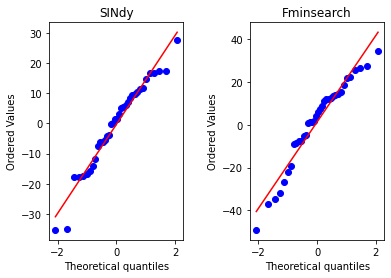

In [187]:
from scipy.stats import probplot
plt.subplot(121)
probplot(diff_sol_res.flatten(), dist="norm", plot=plt)
plt.title('SINdy')
plt.subplot(122)
probplot(diff_res.flatten(), dist="norm", plot=plt)
plt.title('Fminsearch')
# plt.plot(sol_res.t, sol_res.y[0])
# plt.xlim(-2, 2)
plt.subplots_adjust(wspace = 0.5)